## Music generation with LSTM in Keras
* Music generation with LSTM in Keras, https://github.com/unmonoqueteclea/DeepLearning-Notebooks/tree/master/LSTM-Music-Generation

* https://unmonoqueteclea.github.io/rnn/lstm/lstm/

* https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

* http://www.piano-midi.de/

In [1]:
!pwd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(0) # gpu idx

/home/hyejoo/work/repos/Capstone19/02_music


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import glob
import pickle
import numpy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6) # Make the figures a bit bigger
import pydot
    
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
home_music = 'midi_files/'

In [5]:
outDir = 'out'
if not os.path.exists(outDir):
    os.makedirs(outDir)

### Go 

In [6]:
folder_name = 'minyo'

to_Train = True
nb_epoch = 100 
sequence_length = 20
sqln = 'sq'+str(sequence_length)

In [7]:
pickle_name = 'notes_'+folder_name+'_'+sqln+'.pickle'
to_load_from_pickle = False #False 

pickle_name_1 = 'durations_'+folder_name+'_'+sqln+'.pickle'
to_load_from_pickle = False #False 

pickle_name_2 = 'nodu_'+folder_name+'_'+sqln+'.pickle'
to_load_from_pickle = False #False 

In [8]:
if to_load_from_pickle:
    
    notes = pickle.load( open(pickle_name, "rb" ) )
    durations = pickle.load( open(pickle_name_1, "rb" ) )
    nodu = pickle.load( open(pickle_name_2, "rb" ) )
    
else:    
    notes = []
    durations = []
    nodu = []
    for i,file in enumerate(glob.glob(home_music+folder_name+"/*.mid")):
        #print(i, file)
        midi = converter.parse(file)
        print('\r', 'Parsing file ', i, " ",file, end='')
        notes_to_parse = None
        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 

        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            print('------ FLAT Structure --------')

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                str1 = str(element.pitch)
                notes.append(str1)
                str2 = str(element.duration.quarterLength)
                durations.append(str2)
                str3 = [str1, str2]
                nodu.append(str3)
                #print(str3)
                
                #print('pitch --->', str1)
            elif isinstance(element, chord.Chord):
                str1 = '.'.join(str(n) for n in element.normalOrder)
                #print(str1, '<-------', element.normalOrder)
                notes.append(str1)
    
    with open(pickle_name, 'wb') as filepath:
        pickle.dump(notes,filepath)
    with open(pickle_name_1, 'wb') as filepath:
        pickle.dump(durations,filepath)
    with open(pickle_name_2, 'wb') as filepath:
        pickle.dump(nodu,filepath)

 Parsing file  30   midi_files/minyo/둥당기.midddiddd

In [9]:
len(notes)

2170

In [10]:
print(notes[:10])

['E4', 'E4', 'E4', 'A4', 'A4', 'A4', 'A4', 'A4', 'C5', 'C5']


In [11]:
print(durations[:10])

['1.0', '0.5', '0.5', '1.0', '1.0', '0.5', '1.5', '1.0', '0.5', '0.5']


In [12]:
print(nodu[:10])

[['E4', '1.0'], ['E4', '0.5'], ['E4', '0.5'], ['A4', '1.0'], ['A4', '1.0'], ['A4', '0.5'], ['A4', '1.5'], ['A4', '1.0'], ['C5', '0.5'], ['C5', '0.5']]


In [13]:
# Count different possible outputs
n_vocab = (len(set(notes)))
n_vocab

17

In [14]:
n_vocab2 = (len(set(durations)))
n_vocab2

15

In [15]:
n_vocab3 = (len(set(str(item) for item in nodu)))
n_vocab3

101

### data processing

In [16]:
pitchnames = sorted(set(item for item in notes))

In [17]:
print(pitchnames[:10])

['A3', 'A4', 'B-3', 'B-4', 'B3', 'B4', 'C4', 'C5', 'D4', 'D5']


In [18]:
dunames = sorted(set(item for item in durations))

In [19]:
print(dunames)

['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '1/3', '2.0', '2.25', '2.5', '2/3', '3.0', '5.5']


In [20]:
nodunames = sorted(set(str(item) for item in nodu))

In [21]:
print(nodunames[:10])

["['A3', '0.25']", "['A3', '0.5']", "['A4', '0.25']", "['A4', '0.5']", "['A4', '0.75']", "['A4', '1.0']", "['A4', '1.25']", "['A4', '1.5']", "['A4', '1.75']", "['A4', '2.0']"]


In [22]:
print(len(pitchnames), len(dunames), len(nodunames))

17 15 101


In [23]:
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [24]:
print(note_to_int)

{'A3': 0, 'A4': 1, 'B-3': 2, 'B-4': 3, 'B3': 4, 'B4': 5, 'C4': 6, 'C5': 7, 'D4': 8, 'D5': 9, 'E-4': 10, 'E-5': 11, 'E4': 12, 'E5': 13, 'F#4': 14, 'F4': 15, 'G4': 16}


In [25]:
pickle_name_11 = 'note_to_int_'+folder_name+'_'+sqln+'.pickle'
with open(pickle_name_11, 'wb') as filepath:
    pickle.dump(note_to_int, filepath)

In [26]:
duration_to_int = dict((duration, number) for number, duration in enumerate(dunames))

In [27]:
print(duration_to_int)

{'0.0': 0, '0.25': 1, '0.5': 2, '0.75': 3, '1.0': 4, '1.25': 5, '1.5': 6, '1.75': 7, '1/3': 8, '2.0': 9, '2.25': 10, '2.5': 11, '2/3': 12, '3.0': 13, '5.5': 14}


In [28]:
pickle_name_22 = 'duration_to_int_'+folder_name+'_'+sqln+'.pickle'
with open(pickle_name_22, 'wb') as filepath:
    pickle.dump(duration_to_int, filepath)

In [29]:
nodu_to_int = dict((nodu, number) for number, nodu in enumerate(nodunames))

In [30]:
print(nodu_to_int)

{"['A3', '0.25']": 0, "['A3', '0.5']": 1, "['A4', '0.25']": 2, "['A4', '0.5']": 3, "['A4', '0.75']": 4, "['A4', '1.0']": 5, "['A4', '1.25']": 6, "['A4', '1.5']": 7, "['A4', '1.75']": 8, "['A4', '2.0']": 9, "['A4', '2.25']": 10, "['A4', '2.5']": 11, "['A4', '3.0']": 12, "['B-3', '0.25']": 13, "['B-3', '0.5']": 14, "['B-3', '1.0']": 15, "['B-3', '1.5']": 16, "['B-3', '1/3']": 17, "['B-4', '0.0']": 18, "['B-4', '0.25']": 19, "['B-4', '0.5']": 20, "['B-4', '0.75']": 21, "['B-4', '1.0']": 22, "['B-4', '1.5']": 23, "['B-4', '2.0']": 24, "['B-4', '5.5']": 25, "['B3', '0.25']": 26, "['B3', '0.5']": 27, "['B3', '1.0']": 28, "['B3', '1.5']": 29, "['B4', '0.5']": 30, "['B4', '0.75']": 31, "['B4', '1.0']": 32, "['B4', '1.5']": 33, "['B4', '2.0']": 34, "['C4', '0.25']": 35, "['C4', '0.5']": 36, "['C4', '0.75']": 37, "['C4', '1.0']": 38, "['C4', '1.5']": 39, "['C4', '1/3']": 40, "['C4', '2.25']": 41, "['C4', '2.5']": 42, "['C5', '0.25']": 43, "['C5', '0.5']": 44, "['C5', '0.75']": 45, "['C5', '1.0']

In [31]:
nodu2 = []
for i in range(len(nodu)):
    n1 = nodu[i][0] #note
    n2 = nodu[i][1] #duration
    in1 = note_to_int[n1]
    in2 = duration_to_int[n2] 

    
    #n_conv = [in1, in2, diff]
    n_conv = [in1,  in2]
    nodu2.append(n_conv)

In [32]:
print(nodu2[:10])

[[12, 4], [12, 2], [12, 2], [1, 4], [1, 4], [1, 2], [1, 6], [1, 4], [7, 2], [7, 2]]


In [33]:
pickle_name_3 = 'nodu2_'+folder_name+'_'+sqln+'.pickle'
to_load_from_pickle = False #False 

In [34]:
with open(pickle_name_3, 'wb') as filepath:
        pickle.dump(nodu,filepath)

In [35]:
n_vocab4 = (len(set(str(item) for item in nodu2)))
n_vocab4

101

In [36]:
nodunames2 = sorted(set(str(item) for item in nodu2))

In [37]:
print(nodunames2)

['[0, 1]', '[0, 2]', '[1, 10]', '[1, 11]', '[1, 13]', '[1, 1]', '[1, 2]', '[1, 3]', '[1, 4]', '[1, 5]', '[1, 6]', '[1, 7]', '[1, 9]', '[10, 12]', '[10, 1]', '[10, 2]', '[10, 4]', '[10, 6]', '[10, 8]', '[11, 10]', '[11, 1]', '[11, 2]', '[12, 11]', '[12, 13]', '[12, 1]', '[12, 2]', '[12, 3]', '[12, 4]', '[12, 6]', '[13, 2]', '[13, 4]', '[14, 1]', '[14, 2]', '[14, 5]', '[14, 7]', '[15, 11]', '[15, 13]', '[15, 1]', '[15, 2]', '[15, 3]', '[15, 4]', '[15, 6]', '[15, 9]', '[16, 0]', '[16, 10]', '[16, 11]', '[16, 13]', '[16, 1]', '[16, 2]', '[16, 3]', '[16, 4]', '[16, 6]', '[16, 9]', '[2, 1]', '[2, 2]', '[2, 4]', '[2, 6]', '[2, 8]', '[3, 0]', '[3, 14]', '[3, 1]', '[3, 2]', '[3, 3]', '[3, 4]', '[3, 6]', '[3, 9]', '[4, 1]', '[4, 2]', '[4, 4]', '[4, 6]', '[5, 2]', '[5, 3]', '[5, 4]', '[5, 6]', '[5, 9]', '[6, 10]', '[6, 11]', '[6, 1]', '[6, 2]', '[6, 3]', '[6, 4]', '[6, 6]', '[6, 8]', '[7, 13]', '[7, 1]', '[7, 2]', '[7, 3]', '[7, 4]', '[7, 6]', '[7, 9]', '[8, 11]', '[8, 1]', '[8, 2]', '[8, 3]', '[

In [38]:
nodu2_to_int = dict((nodu2, number) for number, nodu2 in enumerate(nodunames2))

In [39]:
print(nodu2_to_int)

{'[0, 1]': 0, '[0, 2]': 1, '[1, 10]': 2, '[1, 11]': 3, '[1, 13]': 4, '[1, 1]': 5, '[1, 2]': 6, '[1, 3]': 7, '[1, 4]': 8, '[1, 5]': 9, '[1, 6]': 10, '[1, 7]': 11, '[1, 9]': 12, '[10, 12]': 13, '[10, 1]': 14, '[10, 2]': 15, '[10, 4]': 16, '[10, 6]': 17, '[10, 8]': 18, '[11, 10]': 19, '[11, 1]': 20, '[11, 2]': 21, '[12, 11]': 22, '[12, 13]': 23, '[12, 1]': 24, '[12, 2]': 25, '[12, 3]': 26, '[12, 4]': 27, '[12, 6]': 28, '[13, 2]': 29, '[13, 4]': 30, '[14, 1]': 31, '[14, 2]': 32, '[14, 5]': 33, '[14, 7]': 34, '[15, 11]': 35, '[15, 13]': 36, '[15, 1]': 37, '[15, 2]': 38, '[15, 3]': 39, '[15, 4]': 40, '[15, 6]': 41, '[15, 9]': 42, '[16, 0]': 43, '[16, 10]': 44, '[16, 11]': 45, '[16, 13]': 46, '[16, 1]': 47, '[16, 2]': 48, '[16, 3]': 49, '[16, 4]': 50, '[16, 6]': 51, '[16, 9]': 52, '[2, 1]': 53, '[2, 2]': 54, '[2, 4]': 55, '[2, 6]': 56, '[2, 8]': 57, '[3, 0]': 58, '[3, 14]': 59, '[3, 1]': 60, '[3, 2]': 61, '[3, 3]': 62, '[3, 4]': 63, '[3, 6]': 64, '[3, 9]': 65, '[4, 1]': 66, '[4, 2]': 67, '[4,

In [40]:
pickle_name_33 = 'nodu2_to_int_'+folder_name+'_'+sqln+'.pickle'
with open(pickle_name_33, 'wb') as filepath:
    pickle.dump(nodu2_to_int, filepath)

### DataInput

In [41]:
len(notes)- sequence_length

2150

In [42]:
len(nodu)

2170

In [43]:
i=0
import numpy as np
print(nodu2[i:i + sequence_length])
print(np.shape(nodu2[i:i + sequence_length]))

[[12, 4], [12, 2], [12, 2], [1, 4], [1, 4], [1, 2], [1, 6], [1, 4], [7, 2], [7, 2], [1, 4], [1, 4], [1, 2], [16, 6], [12, 4], [12, 2], [12, 2], [12, 4], [12, 4], [12, 2]]
(20, 2)


In [44]:
i=0
a = nodu2[i + sequence_length]
print(a)
print(np.shape(a))

[12, 6]
(2,)


In [45]:
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(nodu2) - sequence_length, 1):
    sequence_in = nodu2[i:i + sequence_length]
    sequence_in2 = []
    sequence_out = nodu2[i + sequence_length]  # (2,)
    out = nodu2_to_int[str(sequence_out)]    
    for sq in sequence_in:
        out1 = nodu2_to_int[str(sq)]
        #print(sq, out1)
        sequence_in2.append(out1)
    #print(sequence_in2,'=======> ',out)
    
    network_input.append(sequence_in2)
    network_output.append(out)   

In [46]:
n_vocab4

101

In [47]:
np.shape(network_input)

(2150, 20)

In [48]:
network_input2 = np_utils.to_categorical(network_input)
network_input2 = np.array(network_input2)

In [49]:
np.shape(network_input2)

(2150, 20, 101)

In [50]:
with open("network_input2.pickle", 'wb') as filepath:
        pickle.dump(network_input2,filepath)

In [51]:
print(network_input2[0])
print(np.argmax(network_input2[0]))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
27


In [52]:
network_output = np_utils.to_categorical(network_output)

In [53]:
np.shape(network_output)

(2150, 101)

### Creating model

In [54]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

In [55]:
model = create_network(network_input2, n_vocab4)

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 512)           1257472   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

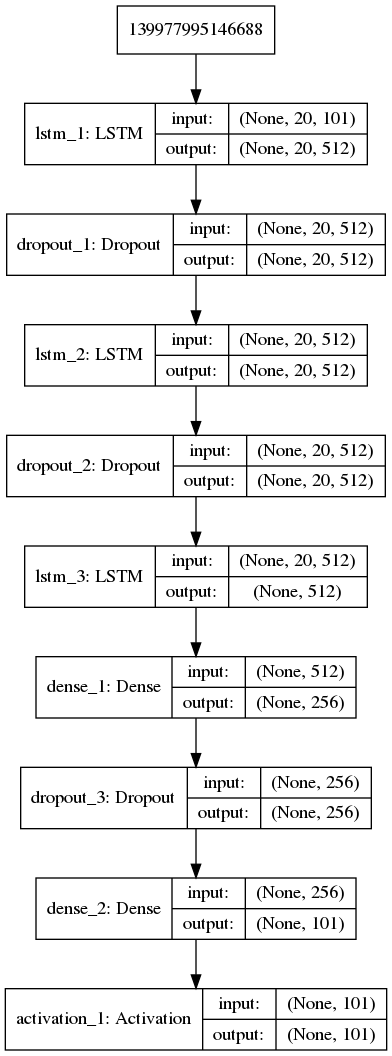

In [57]:
model_name = 'lstm1'
from keras.utils import plot_model
plot_model(model, to_file='{}/model_{}.png'.format(outDir, model_name), show_shapes=True)
from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, model_name))

In [58]:
#filepath = "/content/drive/My Drive/{epoch:02d}-{loss:.4f}.h5"
fnmodel = '{}/model_{}_{}.h5'.format(outDir, folder_name, nb_epoch)
filepath = outDir+"/"+folder_name+"_{epoch:02d}-{loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=1,
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint]

In [59]:
%%time
if to_Train:
    hist = model.fit(network_input2, network_output, epochs=nb_epoch, batch_size=64, 
              callbacks=callbacks_list)
    model.save(fnmodel)
    print('done...saved a model !..{}'.format(fnmodel))
else:
    #model = load_model(fnmodel)
    print('done...loaded a model !..{}'.format(fnmodel))

Epoch 1/100
2150/2150 [==============================] - 3s 2ms/step - loss: 4.0947

Epoch 00001: loss improved from inf to 4.09472, saving model to out/minyo_01-4.0947.h5
Epoch 2/100
2150/2150 [==============================] - 2s 732us/step - loss: 3.4911

Epoch 00002: loss improved from 4.09472 to 3.49110, saving model to out/minyo_02-3.4911.h5
Epoch 3/100
2150/2150 [==============================] - 2s 735us/step - loss: 3.3495

Epoch 00003: loss improved from 3.49110 to 3.34953, saving model to out/minyo_03-3.3495.h5
Epoch 4/100
2150/2150 [==============================] - 2s 724us/step - loss: 3.2721

Epoch 00004: loss improved from 3.34953 to 3.27207, saving model to out/minyo_04-3.2721.h5
Epoch 5/100
2150/2150 [==============================] - 2s 728us/step - loss: 3.1317

Epoch 00005: loss improved from 3.27207 to 3.13168, saving model to out/minyo_05-3.1317.h5
Epoch 6/100
2150/2150 [==============================] - 2s 737us/step - loss: 3.0411

Epoch 00006: loss improved fr

2150/2150 [==============================] - 2s 729us/step - loss: 0.2954

Epoch 00047: loss improved from 0.31803 to 0.29537, saving model to out/minyo_47-0.2954.h5
Epoch 48/100
2150/2150 [==============================] - 2s 737us/step - loss: 0.2611

Epoch 00048: loss improved from 0.29537 to 0.26110, saving model to out/minyo_48-0.2611.h5
Epoch 49/100
2150/2150 [==============================] - 2s 726us/step - loss: 0.2511

Epoch 00049: loss improved from 0.26110 to 0.25106, saving model to out/minyo_49-0.2511.h5
Epoch 50/100
2150/2150 [==============================] - 2s 741us/step - loss: 0.2434

Epoch 00050: loss improved from 0.25106 to 0.24342, saving model to out/minyo_50-0.2434.h5
Epoch 51/100
2150/2150 [==============================] - 2s 732us/step - loss: 0.2053

Epoch 00051: loss improved from 0.24342 to 0.20529, saving model to out/minyo_51-0.2053.h5
Epoch 52/100
2150/2150 [==============================] - 2s 739us/step - loss: 0.2135

Epoch 00052: loss did not impr

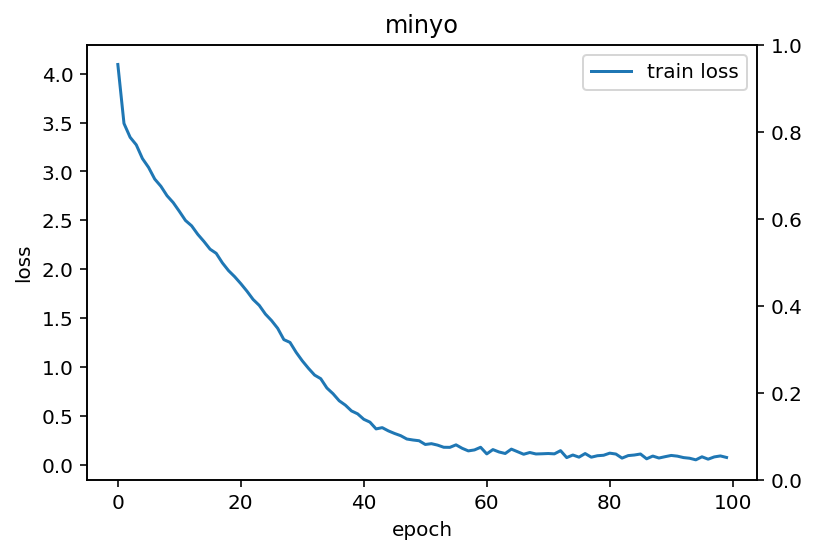

In [60]:
if to_Train:
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'],  label='train loss')
    #loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')
    loss_ax.set_title(folder_name)
    #acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    #acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    #acc_ax.set_ylabel('accuracy')
    #acc_ax.legend(loc='upper center')
    
    fig.savefig('out/{}{}_loss.png'.format(folder_name,sequence_length), dpi=fig.dpi)
    fig.savefig('out/{}{}_loss.svg'.format(folder_name,sequence_length))

In [61]:
fnmodel

'out/model_minyo_100.h5'